# Checkpoint 1

### Importy

In [47]:
import pandas as pd
import numpy as np
import json
import ast

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import pickle

from utils import read_config
from pandas.io.json import json_normalize

### Czytanie konfiguracji z pliku
Wczytywane są klucze do API YouTubowego, które nie powinny być udostępniane publicznie

In [44]:
config = read_config("config.json")
config['dataset_path'] = Path(config['dataset_path'])

### Porównanie plików zawierających kategorie


In [10]:
!diff data/GB_category_id.json data/US_category_id.json

3c3
<  "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2qTj13hkQZk\"",
---
>  "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM\"",
161a162,171
>     "assignable": true
>    }
>   },
>   {
>    "kind": "youtube#videoCategory",
>    "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/SalkJoBWq_smSEqiAx_qyri6Wa8\"",
>    "id": "29",
>    "snippet": {
>     "channelId": "UCBR8-60-B28hp2BmDPdntcQ",
>     "title": "Nonprofits & Activism",


W pliku występują tylko dwie różnice: `etag`, który określa identyfikator zapytania. Jest to w naszym przypadku różnica, która nie ma znaczenia. Plik `data/US_category_id.json` zawiera za to o jedną kategorię więcej, niż brytyjski odpowiednik. Dodatkowa kategoria to `Nonprofits & Activism`. Ponieważ w pozostałych przypadkach pliki są jednakowe, to można użyć pliku `data/US_category_id.json` jako źródło informacji o kategoriach dla amerykańskich i brytyjskich kart trending.

# Wstępne statystyki

### Wczytywanie danych
Dane wczytywane są za pomocą biblioteki Pandas. Plik CSV jest odzielany za pomocą ';'. Dodatkowo przetwarzane są daty z tekstu na znaczniki czasowe. Kolumna `trending_date` nie może być automatycznie konwertowana, ponieważ posiada niestandardowy format daty: `rok.dzień.miesiąc` (odzielony kropkami, gdyby był odzielony ukośnikami `\`, to był by to standardowy format amerykański).

Ponieważ informacje o kategoriach są wspólne (jak było porównywane wcześniej) to obie tabele są łączone w jedną. Aby można odróżnić informację o źródle danych, dodana została kolumna `origin` zawierająca wartości `US` lub `GB`.

In [74]:
def load_csv(path, origin):
    df = pd.read_csv(path, sep=';', parse_dates=['publish_time'])
    df.columns = list(map(str.strip, df.columns))
    df['trending_date'] = pd.to_datetime(df.trending_date, format='%y.%d.%m')
    df['origin'] = origin
    return df


us_videos_df = load_csv(config['dataset_path'] / 'US_videos_5p.csv', 'US')
gb_videos_df = load_csv(config['dataset_path'] / 'GB_videos_5p.csv', 'GB')

videos_df = pd.concat([us_videos_df, gb_videos_df]).reset_index(drop=True)
videos_df['origin'] = videos_df['origin'].astype('category')

# Pierwsze 3 i ostatnie 3 wartości
videos_df.iloc[[0,1,2,-3,-2,-1]]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US
79862,Il-an3K9pjg,2018-06-14,Anne-Marie - 2002 [Official Video],Anne-Marie,NaN,2018-05-08 11:05:08+00:00,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE ▶ http://ad.gt/200...,GB
79863,#NAZWA?,2018-06-14,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,NaN,2018-05-08 20:32:32+00:00,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,GB
79864,4YFo4bdMO8Q,2018-06-14,KYLE - Ikuyo feat. 2 Chainz & Sophia Black [A...,SuperDuperKyle,NaN,2018-05-11 04:06:35+00:00,"Kyle|""SuperDuperKyle""|""Ikuyo""|""2 Chainz""|""Soph...",607552,18271,274,1423,https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg,False,False,False,Debut album 'Light of Mine' out now: http://ky...,GB


### Podstawowe informacje o kolumnach

In [75]:
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79865 entries, 0 to 79864
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                79865 non-null  object             
 1   trending_date           79865 non-null  datetime64[ns]     
 2   title                   79865 non-null  object             
 3   channel_title           79865 non-null  object             
 4   category_id             3932 non-null   float64            
 5   publish_time            79865 non-null  datetime64[ns, UTC]
 6   tags                    79865 non-null  object             
 7   views                   79865 non-null  int64              
 8   likes                   79865 non-null  int64              
 9   dislikes                79865 non-null  int64              
 10  comment_count           79865 non-null  int64              
 11  thumbnail_link          79865 non-null  o

## Popsute ID filmów

### Zliczanie ID filmów

Zliczamy ID filmów aby sprawdzić, czy występują bardzo popularne filmy. Okazało się jednak, że najczęstrzym ID filmu jest `#NAZWA?`. Pozatym widać, że niektóre filmy są popularne przez wiele dni. Należy jednak sprawdzić, czy te same filmy nie są popularne w różnych krajach w tym samym dniu (liczone dwa razy).

In [76]:
videos_df.video_id.value_counts()

#NAZWA?        727
8h--kFui1JA     66
vjSohj-Iclc     62
VYOjWnS4cMY     61
l884wKofd54     61
              ... 
lbOXPpVejJ0      1
HBS9783c0BI      1
7FgazlhALyE      1
lRxAWujpMmA      1
f13X2hLYAhk      1
Name: video_id, Length: 8511, dtype: int64

### Naprawianie zepsutych ID

Pobraliśmy dane za pomocą klasy `YTDownloader` z pliku `utils.py` a następnie zapisaliśmy je w formacie `pickle` do późniejszego wykorzystania. Aby pobrać unikalne ID filmu użyliśmy `Search YouTube API`, gdzie wyszukiwaliśmy filmy o konretnym tytule i od konretnego autora.

In [81]:
def load_missing_ids(path):
    with open(path, 'rb') as fh:
        return{k: v['items'][0]['id']['videoId'] for k, v in pickle.load(fh).items()}

us_missing = load_missing_ids(config['dataset_path'] / 'us_missing_id.pkl')
gb_missing = load_missing_ids(config['dataset_path'] / 'gb_missing_id.pkl')

for (title, channel), idx in {**us_missing, **gb_missing}.items():
    videos_df.loc[(videos_df.title == title) & (videos_df.channel_title == channel), 'video_id'] = idx 

## Statystyki i wykresy

Rozkłady wartości odtworzeń, lików, dislików i komentarzy

Distribution plot for 'views' attribute


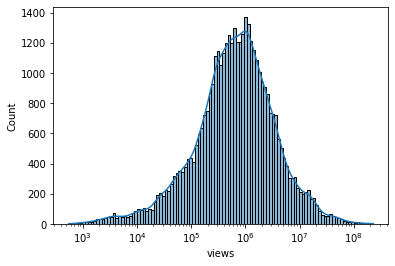

Distribution plot for 'likes' attribute


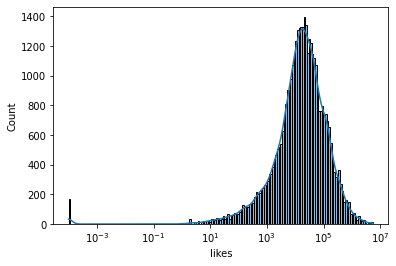

Distribution plot for 'dislikes' attribute


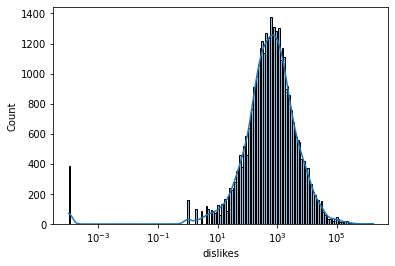

Distribution plot for 'comment_count' attribute


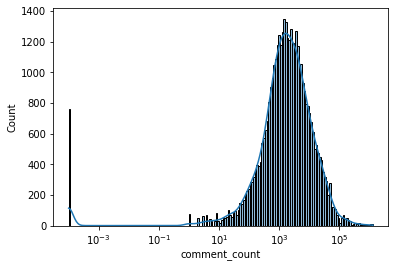

In [82]:
columns = ['views', 'likes', 'dislikes', 'comment_count']
# Replace 0s for log scale
us_videos_df[columns] = us_videos_df[columns].replace(0, 0.0001)

for col in columns:
    print(f'Distribution plot for \'{col}\' attribute')
    sns.histplot(us_videos_df, x=col, kde=True, log_scale=True)
    plt.show()

Ilość różnych klas kategorii i równocześnie pokazanie niezbalansowania zbioru (przynajmniej przed wykorzystaniem metody semi-supervised learning)

In [83]:
# Read categories
with open(config['dataset_path'] / 'US_category_id.json', 'r') as f:
    us_categories = json.load(f)['items']

df_us_categories = pd.DataFrame(us_categories)
df_us_categories = df_us_categories.join(json_normalize(df_us_categories['snippet'].apply(lambda x: ast.literal_eval(str(x))).tolist()).add_prefix('snippet_'))
df_us_categories.drop(columns=['snippet', 'kind', 'etag', 'snippet_channelId', 'snippet_assignable'], inplace=True)
df_us_categories['id'] = df_us_categories['id'].astype('float64')
df_us_categories.rename(columns={'snippet_title': 'category_text'}, inplace=True)

df_us_categories

<ipython-input-83-c4b28831c080>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_us_categories = df_us_categories.join(json_normalize(df_us_categories['snippet'].apply(lambda x: ast.literal_eval(str(x))).tolist()).add_prefix('snippet_'))


,id,category_text
0,1.0,Film & Animation
1,2.0,Autos & Vehicles
2,10.0,Music
3,15.0,Pets & Animals
4,17.0,Sports
5,18.0,Short Movies
6,19.0,Travel & Events
7,20.0,Gaming
8,21.0,Videoblogging
9,22.0,People & Blogs


In [84]:
# Join data information
us_videos_df_merged = us_videos_df.merge(df_us_categories, left_on='category_id', right_on='id', how='left')
us_videos_df_merged.drop(columns=['id'], inplace=True)
us_videos_df_merged

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_text
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US,NaN
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US,NaN
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US,NaN
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,NaN,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US,NaN
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,NaN,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,2018-06-14,The Cat Who Caught the Laser,AaronsAnimals,NaN,2018-05-18 13:00:04+00:00,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160.0,1385.0,2657.0,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals,US,NaN
40945,1h7KV2sjUWY,2018-06-14,True Facts : Ant Mutualism,zefrank1,NaN,2018-05-18 01:00:06+00:00,[none],1064798,60008.0,382.0,3936.0,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN,US,NaN
40946,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,NaN,2018-05-18 17:34:22+00:00,I gave safiya nygaard a perfect hair makeover ...,1066451,48068.0,1032.0,3992.0,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,US,NaN
40947,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,How It Should Have Ended,NaN,2018-05-17 17:00:04+00:00,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957.0,2846.0,13088.0,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,US,NaN


<AxesSubplot:xlabel='count', ylabel='category_text'>

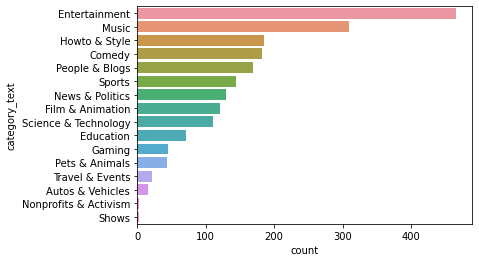

In [85]:
# Plot results
sns.countplot(data=us_videos_df_merged, y="category_text", order = us_videos_df_merged["category_text"].value_counts().index)

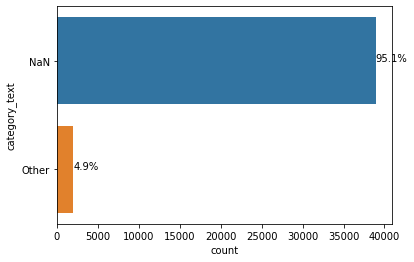

In [86]:
us_videos_df_merged_temp = us_videos_df_merged.fillna('NaN')
us_videos_df_merged_temp.loc[us_videos_df_merged_temp["category_text"] != 'NaN', "category_text"] = 'Other'
ax = sns.countplot(data=us_videos_df_merged_temp, y="category_text", order = us_videos_df_merged_temp["category_text"].value_counts().index)
# Add percentage
total = len(us_videos_df_merged_temp['category_text'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

### Zmiany reprezentacji danych